In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/

/gdrive/My Drive/Tesi


In [ ]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 9.3 MB/s eta 0:00:00


In [ ]:
import random
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
miss_rate = 0.3
batch_size = 100
hint_rate = 0.9
alpha = 100
iterations = 10000
epochs = 100
learning_rate = 5e-5

In [ ]:
def binary_sampler(p, rows, cols):
  '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
  unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix

In [ ]:
data_x = pd.read_csv("letter.csv")  #original data
no = data_x.shape[0]
dim = data_x.shape[1]
data_x

,Cat 1,Cat 2,Cat 3,Cat 4,Cat 5,Cat 6,Cat 7,Cat 8,Cat 9,Cat 10,Cat 11,Cat 12,Cat 13,Cat 14,Cat 15,Cat 16
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


In [ ]:
data_m = binary_sampler(1-miss_rate, no, dim)   #indicator matrix for missing components
miss_data_x = data_x.copy()
miss_data_x[data_m == 0] = np.nan               #data with missing values
miss_data_x

,Cat 1,Cat 2,Cat 3,Cat 4,Cat 5,Cat 6,Cat 7,Cat 8,Cat 9,Cat 10,Cat 11,Cat 12,Cat 13,Cat 14,Cat 15,Cat 16
0,2.0,NaN,NaN,5.0,1.0,8.0,13.0,NaN,6.0,NaN,10.0,NaN,NaN,8.0,0.0,8.0
1,5.0,12.0,3.0,7.0,2.0,10.0,5.0,5.0,4.0,NaN,3.0,9.0,2.0,8.0,4.0,10.0
2,4.0,NaN,NaN,NaN,6.0,10.0,6.0,2.0,6.0,10.0,3.0,NaN,3.0,7.0,3.0,9.0
3,7.0,11.0,NaN,NaN,NaN,NaN,9.0,NaN,6.0,4.0,4.0,10.0,6.0,10.0,NaN,8.0
4,2.0,1.0,3.0,NaN,1.0,NaN,NaN,6.0,6.0,NaN,NaN,NaN,NaN,7.0,5.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2.0,2.0,NaN,3.0,2.0,NaN,7.0,7.0,NaN,NaN,6.0,4.0,2.0,8.0,3.0,7.0
19996,NaN,10.0,8.0,8.0,4.0,NaN,NaN,6.0,9.0,NaN,NaN,13.0,2.0,9.0,3.0,7.0
19997,NaN,9.0,NaN,7.0,5.0,NaN,NaN,3.0,NaN,11.0,9.0,NaN,2.0,NaN,2.0,4.0
19998,2.0,3.0,4.0,2.0,1.0,8.0,7.0,2.0,6.0,NaN,6.0,8.0,NaN,9.0,5.0,8.0


In [ ]:
h_dim = int(dim)          #latent dimension, z 
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(miss_data_x)
norm_data_x = np.nan_to_num(norm_data, 0)
norm_data_x

array([[0.13333333, 0.        , 0.        , ..., 0.5       , 0.        ,
        0.53333333],
       [0.33333333, 0.8       , 0.2       , ..., 0.5       , 0.26666667,
        0.66666667],
       [0.26666667, 0.        , 0.        , ..., 0.42857143, 0.2       ,
        0.6       ],
       ...,
       [0.        , 0.6       , 0.        , ..., 0.        , 0.13333333,
        0.26666667],
       [0.13333333, 0.2       , 0.26666667, ..., 0.57142857, 0.33333333,
        0.53333333],
       [0.26666667, 0.6       , 0.4       , ..., 0.        , 0.13333333,
        0.53333333]])

In [ ]:
#input_shape = np.arange(6400).reshape(200, 32)
#input_shape = input_shape.shape
input = np.concatenate([norm_data_x, data_m], axis=1)
input_shape = input.shape[1:] 
input_shape

(32,)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32)]              0         
                                                                 
 Hidden1 (Dense)             (None, 64)                2112      
                                                                 
 Hidden2 (Dense)             (None, 128)               8320      
                                                                 
 Output (Dense)              (None, 16)                2064      
                                                                 
Total params: 12,496
Trainable params: 12,496
Non-trainable params: 0
_________________________________________________________________


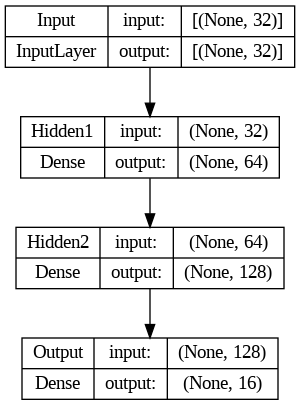

In [ ]:
def get_discriminator(input_shape, seed = seed):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L2(0.01))(input_layer)
    #x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(hidden_layer1)
    #dropout1 = tfkl.Dropout(0.3, seed=seed)(x)
    hidden_layer2 = tfkl.Dense(units=128, activation='relu', name='Hidden2', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L2(0.01))(hidden_layer1)
    #x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(hidden_layer2)
    #dropout2 = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(units=16, activation='sigmoid', name='Output')(hidden_layer2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='discriminator')

    # Return the model
    return model

discriminator = get_discriminator(input_shape)
discriminator.summary()
#display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32)]              0         
                                                                 
 Hidden1 (Dense)             (None, 64)                2112      
                                                                 
 Hidden2 (Dense)             (None, 128)               8320      
                                                                 
 Output (Dense)              (None, 16)                2064      
                                                                 
Total params: 12,496
Trainable params: 12,496
Non-trainable params: 0
_________________________________________________________________


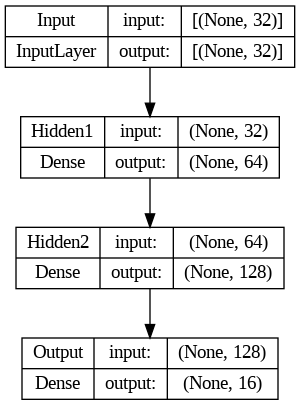

In [ ]:
def get_generator(input_shape, seed = seed):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    hidden_layer1 = tfkl.Dense(units=64, activation='relu', name='Hidden1', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L2(0.01))(input_layer)
    #x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(hidden_layer1)
    #dropout1 = tfkl.Dropout(0.3, seed=seed)(x)
    hidden_layer2 = tfkl.Dense(units=128, activation='relu', name='Hidden2', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L2(0.01))(hidden_layer1)
    #x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(hidden_layer2)
    #dropout2 = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(units=16, activation='sigmoid', name='Output')(hidden_layer2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='generator')

    # Return the model
    return model

generator = get_generator(input_shape)
generator.summary()
#display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True)

In [ ]:
class GAN(tfk.Model):
    def __init__(self, discriminator, generator, h_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.h_dim = h_dim

        #self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.mse_loss_tracker = tfk.metrics.Mean(name="mse_loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            #self.loss_tracker,
            self.mse_loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]

    @tf.function
    def train_step(self, data):
        # Sample random points in the latent space
        #batch_size = tf.shape(real_images)[0]
        x, m = data
        x = tf.cast(x, tf.float32)
        m = tf.cast(m, tf.float32)
        print(x.shape)
        print(m.shape)
        #print(x, y)
        #m = tf.ones(shape = (200, 16))
        #m = np.copy(x)
        #m = tf.convert_to_tensor(m)
        #m[m != 0] = 1
        z = np.random.uniform(0, 0.01, size = [batch_size, h_dim])
        #z = tf.random.normal(shape=(batch_size, self.latent_dim))
        h_temp = binary_sampler(hint_rate, batch_size, h_dim)
        h = m * h_temp
        x = m * x + (1-m) * z 

        # Generate fake data from z
        input_g = tf.concat(values = [x, m], axis = 1) 
        #input_g = tf.reshape(input_g, (10, 200, 32, 1))
        print(input_g.shape)
        g_sample = self.generator(input_g)
        print(g_sample.shape)

        # Impute the generated data where the data is missing
        hat_x = x * m + g_sample * (1-m)

        # Train the discriminator
        with tf.GradientTape() as tape:
            input_d = tf.concat(values = [hat_x, h], axis = 1) 
            d_prob = self.discriminator(input_d)
            d_loss = -tf.reduce_mean(m * tf.math.log(d_prob + 1e-8) + (1-m) * tf.math.log(1. - d_prob + 1e-8))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        #mse_loss = tf.reduce_mean((m * x - m * g_sample)**2) / tf.reduce_mean(m)

        # Sample random points in the latent space
        #z = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create misleading labels for fake images so that they correspond to class 1
        #misleading_labels = tf.ones((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            g_sample = self.generator(input_g)
            hat_x = x * m + g_sample * (1-m)
            d_prob = self.discriminator(input_d)
            d_loss = -tf.reduce_mean(m * tf.math.log(d_prob + 1e-8) + (1-m) * tf.math.log(1. - d_prob + 1e-8))
            g_loss_temp = -tf.reduce_mean((1-m) * tf.math.log(d_prob + 1e-8))
            mse_loss = tf.reduce_mean((m * x - m * g_sample)**2) / tf.reduce_mean(m)
            g_loss = g_loss_temp + alpha * mse_loss 
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        #loss += g_loss

        # Update metrics
        #self.loss_tracker.update_state(loss)
        self.mse_loss_tracker.update_state(mse_loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            #"loss": self.loss_tracker.result(),
            "mse_loss": self.mse_loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [ ]:
gan = GAN(
    discriminator = get_discriminator(input_shape), 
    generator = get_generator(input_shape), 
    h_dim = h_dim
)
gan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [ ]:
history = gan.fit(
    x = norm_data_x, 
    y = data_m,
    epochs = epochs, 
    batch_size = batch_size,
    #callbacks = [GANMonitor(name='vanilla', gray=True)],
    verbose = 2
).history

Epoch 1/100
(100, 16)
(100, 16)
(100, 32)
(100, 16)
(100, 16)
(100, 16)
(100, 32)
(100, 16)
200/200 - 6s - mse_loss: 0.0614 - d_loss: 0.7352 - g_loss: 6.3580 - 6s/epoch - 31ms/step
Epoch 2/100
200/200 - 2s - mse_loss: 0.0316 - d_loss: 0.6020 - g_loss: 3.3008 - 2s/epoch - 9ms/step
Epoch 3/100
200/200 - 1s - mse_loss: 0.0275 - d_loss: 0.5520 - g_loss: 2.8855 - 1s/epoch - 6ms/step
Epoch 4/100
200/200 - 1s - mse_loss: 0.0252 - d_loss: 0.5078 - g_loss: 2.6703 - 1s/epoch - 5ms/step
Epoch 5/100
200/200 - 1s - mse_loss: 0.0232 - d_loss: 0.4607 - g_loss: 2.5007 - 1s/epoch - 6ms/step
Epoch 6/100
200/200 - 1s - mse_loss: 0.0215 - d_loss: 0.4123 - g_loss: 2.3554 - 1s/epoch - 7ms/step
Epoch 7/100
200/200 - 1s - mse_loss: 0.0198 - d_loss: 0.3678 - g_loss: 2.2189 - 1s/epoch - 6ms/step
Epoch 8/100
200/200 - 1s - mse_loss: 0.0181 - d_loss: 0.3298 - g_loss: 2.0873 - 1s/epoch - 5ms/step
Epoch 9/100
200/200 - 1s - mse_loss: 0.0165 - d_loss: 0.2993 - g_loss: 1.9594 - 1s/epoch - 6ms/step
Epoch 10/100
200/20

In [ ]:
gan.generator.save('gan_generator')

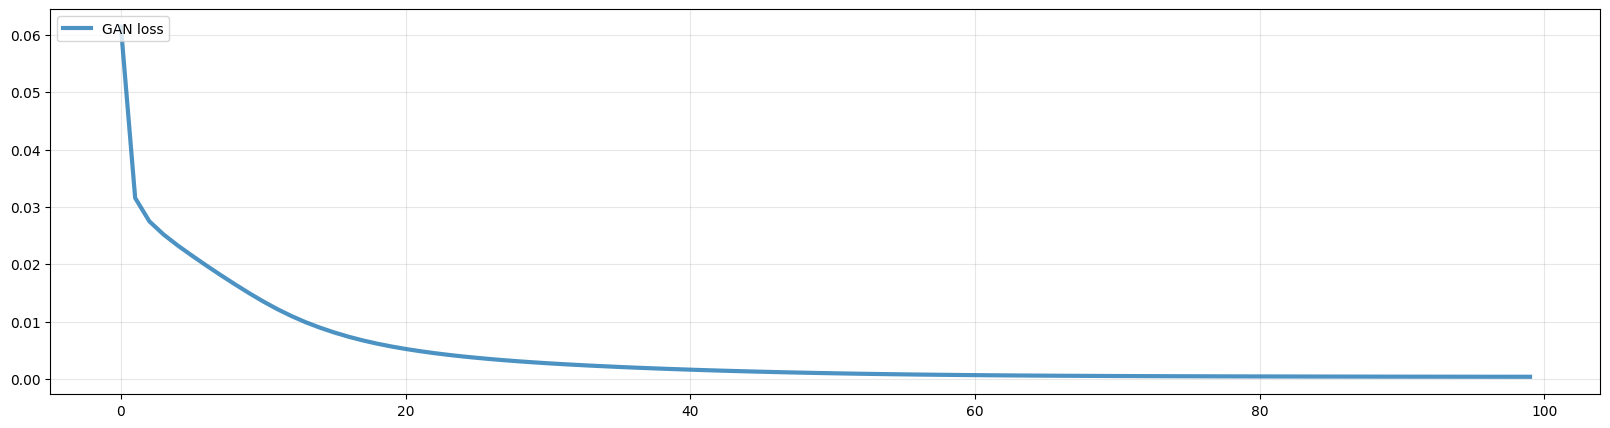

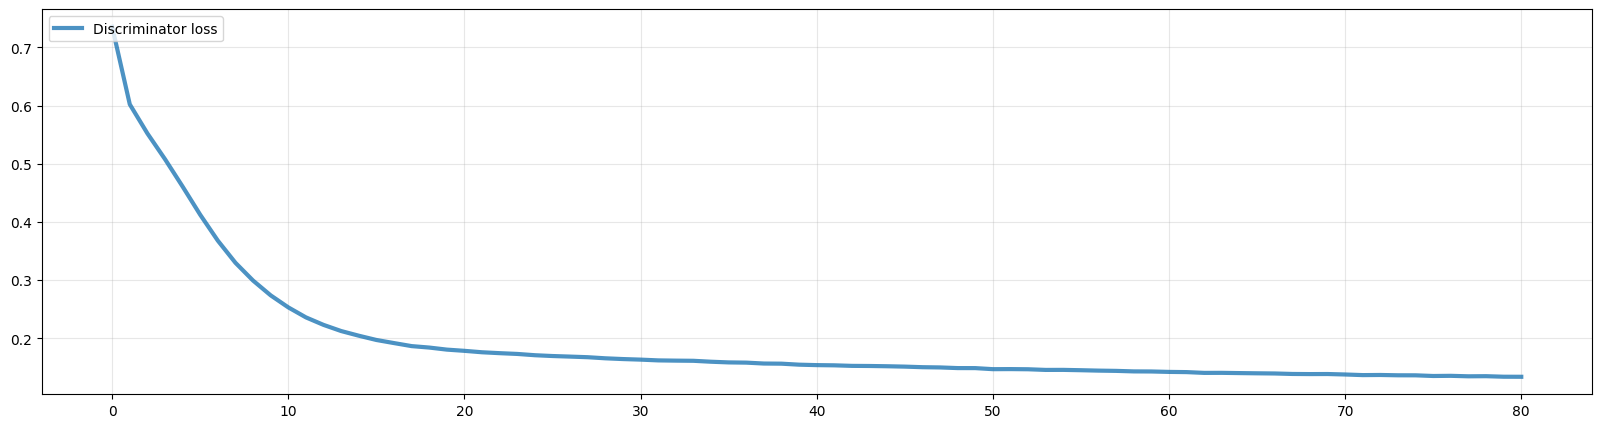

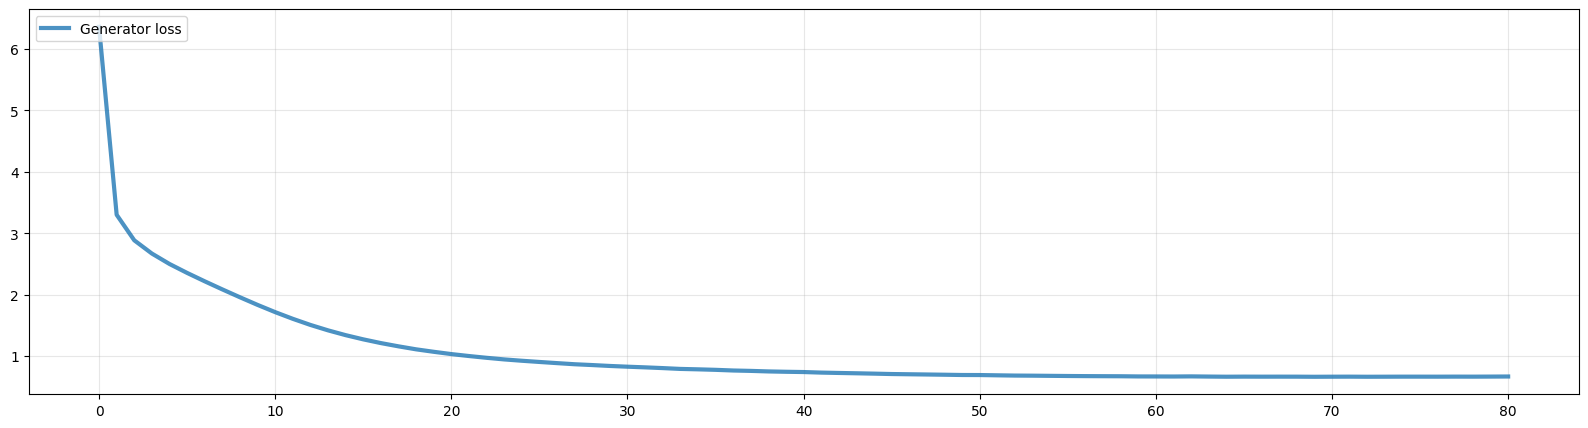

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['mse_loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

In [ ]:
gan_generator = tfk.models.load_model('gan_generator')

In [ ]:
Z = np.random.uniform(0, 0.01, size = [no, dim])
M = data_m
X = norm_data_x          
X = M * X + (1-M) * Z

input_g = tf.concat(values = [X, M], axis = 1) 
imputed_data = gan_generator(input_g).numpy()
#data = scaler.inverse_transform(imputed_data)
#data = np.round(data)
orig_data = scaler.fit_transform(data_x)

nominator = np.sum(((1-data_m) * orig_data - (1-data_m) * imputed_data)**2)
denominator = np.sum(1-data_m)
rmse = np.sqrt(nominator/float(denominator))
rmse

0.1978517256835186

In [ ]:
data_m

array([[1, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1]])

In [ ]:
x = pd.DataFrame(orig_data)
x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.133333,0.533333,0.200000,0.333333,0.066667,0.533333,0.866667,0.000000,0.400000,0.400000,0.666667,0.533333,0.000000,0.533333,0.000000,0.533333
1,0.333333,0.800000,0.200000,0.466667,0.133333,0.666667,0.333333,0.333333,0.266667,0.866667,0.200000,0.600000,0.133333,0.533333,0.266667,0.666667
2,0.266667,0.733333,0.400000,0.533333,0.400000,0.666667,0.400000,0.133333,0.400000,0.666667,0.200000,0.466667,0.200000,0.466667,0.200000,0.600000
3,0.466667,0.733333,0.400000,0.400000,0.200000,0.333333,0.600000,0.266667,0.400000,0.266667,0.266667,0.666667,0.400000,0.666667,0.133333,0.533333
4,0.133333,0.066667,0.200000,0.066667,0.066667,0.533333,0.400000,0.400000,0.400000,0.400000,0.333333,0.600000,0.066667,0.466667,0.333333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.133333,0.133333,0.200000,0.200000,0.133333,0.466667,0.466667,0.466667,0.400000,0.400000,0.400000,0.266667,0.133333,0.533333,0.200000,0.466667
19996,0.466667,0.666667,0.533333,0.533333,0.266667,0.266667,0.533333,0.400000,0.600000,0.800000,0.600000,0.866667,0.133333,0.600000,0.200000,0.466667
19997,0.400000,0.600000,0.400000,0.466667,0.333333,0.400000,0.733333,0.200000,0.466667,0.733333,0.600000,0.333333,0.133333,0.800000,0.133333,0.266667
19998,0.133333,0.200000,0.266667,0.133333,0.066667,0.533333,0.466667,0.133333,0.400000,0.666667,0.400000,0.533333,0.066667,0.600000,0.333333,0.533333


In [ ]:
y = pd.DataFrame((imputed_data))
y

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.153100,0.311553,0.195119,0.297483,0.094196,0.542302,0.843742,0.314796,0.390710,0.409223,0.689081,0.339826,0.179627,0.498726,0.065884,0.534824
1,0.295378,0.797271,0.220238,0.464285,0.149069,0.673805,0.328169,0.316306,0.255071,0.390770,0.207983,0.604799,0.124653,0.500278,0.237279,0.669533
2,0.264299,0.329296,0.241903,0.313552,0.400641,0.675353,0.398835,0.147145,0.396712,0.680889,0.208605,0.341406,0.179377,0.426185,0.195914,0.604766
3,0.466081,0.747423,0.243853,0.309324,0.230776,0.275133,0.611571,0.345491,0.389110,0.259536,0.256412,0.674380,0.383946,0.649616,0.236419,0.534645
4,0.129051,0.111118,0.182529,0.272630,0.084020,0.272875,0.359320,0.387258,0.389924,0.399545,0.317778,0.341718,0.180172,0.423762,0.299548,0.670272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.139566,0.144075,0.184247,0.179794,0.108074,0.269986,0.465810,0.466727,0.364145,0.389715,0.394276,0.263565,0.122697,0.499083,0.171508,0.463427
19996,0.282486,0.675115,0.528329,0.535333,0.266547,0.273608,0.358743,0.382493,0.614740,0.389740,0.308956,0.834102,0.126184,0.575235,0.185379,0.463931
19997,0.265908,0.614478,0.240331,0.472963,0.326081,0.270985,0.351749,0.194283,0.364151,0.741947,0.610117,0.333019,0.133718,0.354990,0.132954,0.271918
19998,0.142889,0.200450,0.249923,0.154415,0.099061,0.538243,0.466663,0.149225,0.392084,0.391286,0.393945,0.533772,0.199679,0.575092,0.312157,0.534479
